# **Selenium**

**장점**
* table 형태가 아니더라도 내가 얻고 싶은 정보를 입맛대로 가져올 수 있다.
* 여러 페이지에서 정보를 가져올 수 있다.
* 로그인, 마우스 클릭, 캡쳐 등 동적으로 많은 자동화 업무를 할 수 있다.

**단점**
* 컴퓨터 사양에 따라 속도가 달라 원하는 정보를 추출하는데 시간이 걸릴 수도 있다.<br>
* 불러오는 속도와 python의 실행 속도가 맞지 않으면 오류가 난다.

## **세계 축구선수 Top200**


* **학습 목표**
    * 200위까지 선수명, 포지션, 나이, 국적, 소속, Market Value가 나타나는 데이터 프레임을 만들 수 있다.
    * 국적, 소속, 포지션 등을 통해 시각화하고, 데이터를 분석할 수 있다.

<div markdown="1" style="text-align:center; margin-bottom:10px">        
    <img src="./images/soccer_html.PNG" width="50%">
</div>


## **1) Chrome 창 열기**

In [164]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By  

chrome_options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

[WDM] - Downloading: 100%|██████████| 6.80M/6.80M [00:03<00:00, 2.14MB/s]


## **2) 사이트 이동**

In [165]:
# Chrome 열기
url = 'https://www.transfermarkt.com'
driver.get(url)

## **3) 팝업창 or iframe이 있는 경우**

In [171]:
# 페이지 전환
privacy_iframe = 'sp_message_iframe_764226'
driver.switch_to.frame(privacy_iframe)

In [172]:
# 팝업창 닫기 클릭
privacy_css = '#notice > div.message-component.message-row.mobile-reverse > div:nth-child(2) > button'
driver.find_element(By.CSS_SELECTOR, privacy_css).click()

In [168]:
# 원래 페이지로 복구
driver.switch_to.default_content()

## **4) 클릭이 되지 않을 때 : javascript 명령어로 클릭하기**

In [169]:
import time

# Market Values 네비게이션 바 클릭
nav_css = '#main > header > nav > ul > li:nth-child(4) > span'
driver.find_element(By.CSS_SELECTOR, nav_css).click()
time.sleep(2)

# onclick인 경우
players_css = '#main > header > nav > ul > li:nth-child(4) > div > div:nth-child(2) > ul > li:nth-child(2) > a'
players_url = driver.find_element(By.CSS_SELECTOR, players_css)
driver.execute_script('arguments[0].click();', players_url)

## **5) 데이터 프레임 만들기**

In [173]:
import re
import pandas as pd

rank_n = 200            # 몇 위까지 수집할 것인가
cnt = 0                 # 수집된 데이터를 카운트 하기 위한 변수
page = 1                # 페이지를 넘기기 위한 변수
rows = []               # 데이터 행을 모을 변수

print('Start | ', end='')
while True:
    print(f'{page}페이지 > ', end='')
    # 페이지의 선수 목록
    players = driver.find_elements(By.CSS_SELECTOR, 'table.items > tbody > tr')

    for player in players:
        # 정보(순위, 이름, 포지션, 나이, 국적, 소속, value)접근
        rank = player.find_element(By.CSS_SELECTOR, f'td:nth-child({1})').text
        name, position = player.find_element(By.CSS_SELECTOR, f'td:nth-child({2})').text.split('\n')
        age = player.find_element(By.CSS_SELECTOR, f'td:nth-child({3})').text
        nat_sel = player.find_elements(By.CSS_SELECTOR, f'td:nth-child({4}) > img')
        ## 한국의 경우 Korea, South로 표기됨을 확인 ,가 아닌 다른 값으로 다중 국적을 구분하고자 함.
        nationality = '|'.join([nat.get_attribute('title') for nat in nat_sel])
        club = player.find_element(By.CSS_SELECTOR, f'td:nth-child({5}) > a').get_attribute('title')
        value_text = player.find_element(By.CSS_SELECTOR, f'td:nth-child({6}) > a').text
        value = re.sub('[^0-9.]','',value_text)

        # player 한 명이 끝날 때마다 카운트, row에 정보 추가
        cnt += 1
        rows.append([rank, name, age, position, nationality, club, value])

        # 지정한 rank_n까지 수집되면 멈추기(for문 나가기)
        if cnt >= rank_n:
            break
    
    # 지정한 rank_n까지 도달하지 못했다면 다음 페이지로 넘기고 아니면 멈추기(while문 나가기)
    if cnt < rank_n:
        page += 1
        page_css = '#yw1 > div.pager > ul > li.tm-pagination__list-item.tm-pagination__list-item--icon-next-page > a'
        driver.find_element(By.CSS_SELECTOR, page_css).click()
        time.sleep(5)
    else:
        break

print('End')

columns = ['rank', 'name', 'age', 'position', 'nationality', 'club', 'value']
df = pd.DataFrame(rows, columns=columns)
df = df.set_index('rank')
df

Start | 1페이지 > 2페이지 > 3페이지 > 4페이지 > 5페이지 > 6페이지 > 7페이지 > 8페이지 > End


,name,age,position,nationality,club,value
rank,,,,,,
1,Kylian Mbappé,24,Centre-Forward,France|Cameroon,Paris Saint-Germain,180.00
2,Erling Haaland,22,Centre-Forward,Norway,Manchester City,170.00
3,Jude Bellingham,19,Central Midfield,England,Borussia Dortmund,120.00
4,Vinicius Junior,22,Left Winger,Brazil|Spain,Real Madrid,120.00
5,Jamal Musiala,20,Attacking Midfield,Germany|England,Bayern Munich,110.00
...,...,...,...,...,...,...
196,Khéphren Thuram,22,Defensive Midfield,France|Guadeloupe,OGC Nice,32.00
197,Robert Sánchez,25,Goalkeeper,Spain|England,Brighton & Hove Albion,32.00
198,Harvey Barnes,25,Left Winger,England|Scotland,Leicester City,32.00


# **6) 정보 추출하기**

### **most valuable player는 어떤 선수일까?**
* 상위 rank에 있는 선수들이 어떤 position을 갖고 있으며 어느 club에 소속되어 있는지 시각적으로 살펴볼 수 있다.
* position의 경우 Centre-Back, Centre-Midfield, Left Winger, Defensive Midfield, Centre-Forward 순으로 많았다.
* club의 경우 Bayern Munich, Chelsea FC, Liverpool FC, Arsenal FC, Paris Saint-Germain 순으로 많았다.

> 용어 정리
> * Centre-Back : 센터백(중앙 수비수)
> * Centre-Midfilde : 중앙 미드필더(경기 전체 조율)
> * Centre-Forward : 중앙 공격수 
> * Left Winger : 왼쪽 미드필더
> * Defensive Midfield : 수비형 미드필더

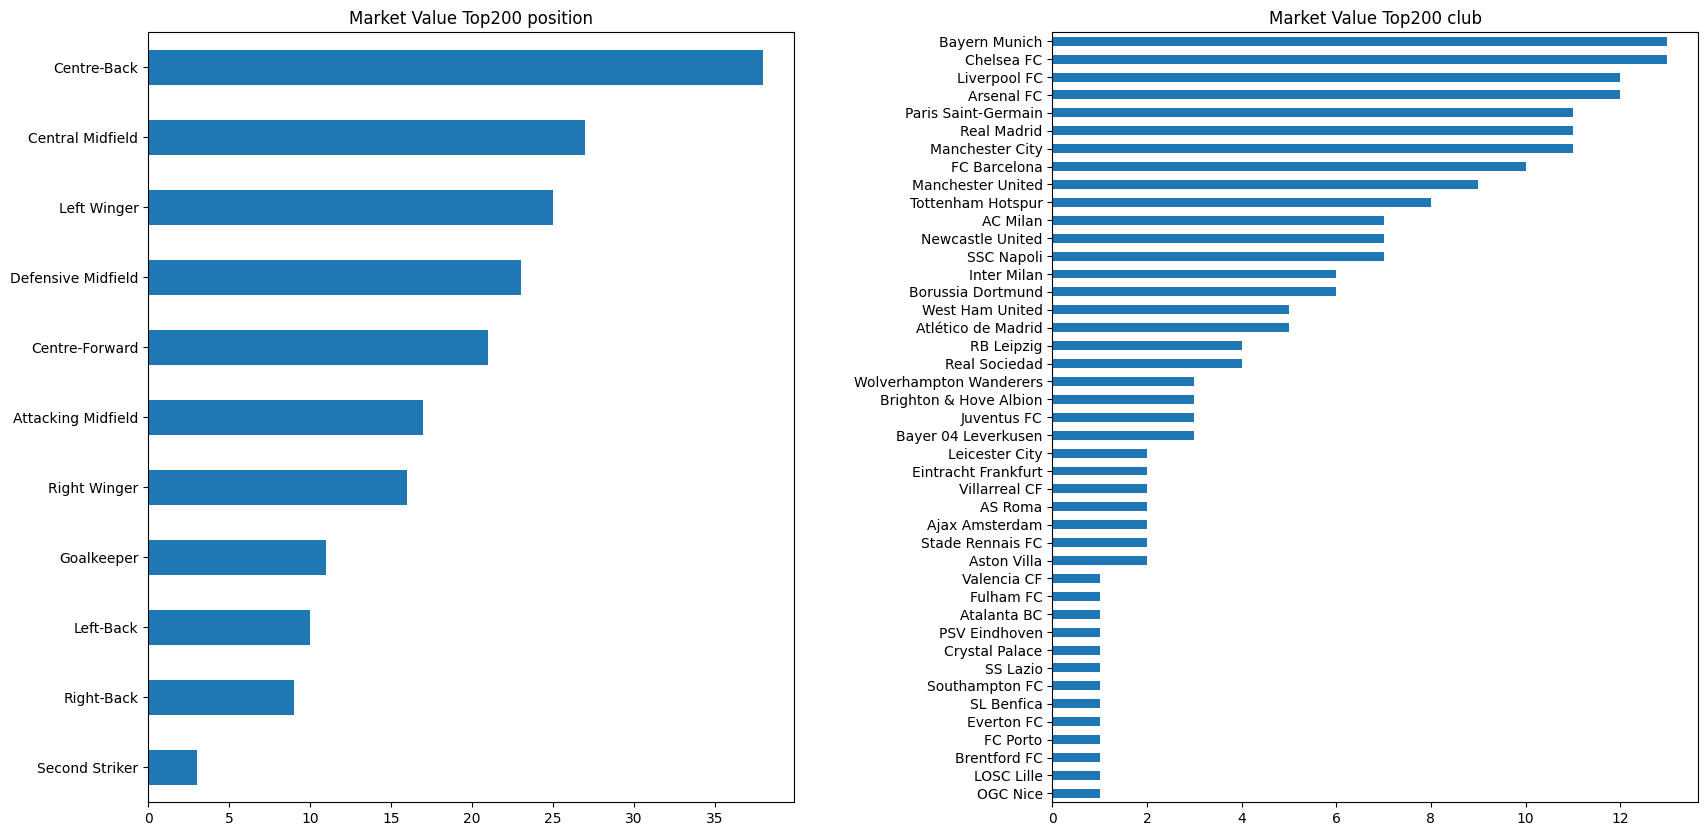

In [ ]:
import matplotlib.pyplot as plt 

cols = ['position', 'club']
rank_lst = []

fig = plt.figure(figsize=(20, 10))
for i, col in enumerate(cols):
    ax = fig.add_subplot(1, 2, i+1)
    temp_df = df[col].value_counts()
    rank_lst.append(list(temp_df.index))
    temp_df.plot.barh(ax=ax)
    ax.set_title(f'Market Value Top200 {col}')
    ax.invert_yaxis()

plt.subplots_adjust(wspace=0.4)

### **most valuable player들은 어느 club에 많을까?**
* 선수들의 포함 여부를 통해 club의 특징을 파악할 수 있다.
* Bayem Munich club이 most valueable player를 가장 많이 보유하고 있지만, Manchester City club이 더 다양한 position에 선수들이 분포되어 있다.
* 각 club에서 Centre-Back, Central Midfield, Left Winger position에 우수한 선수들을 보유하고 있다.

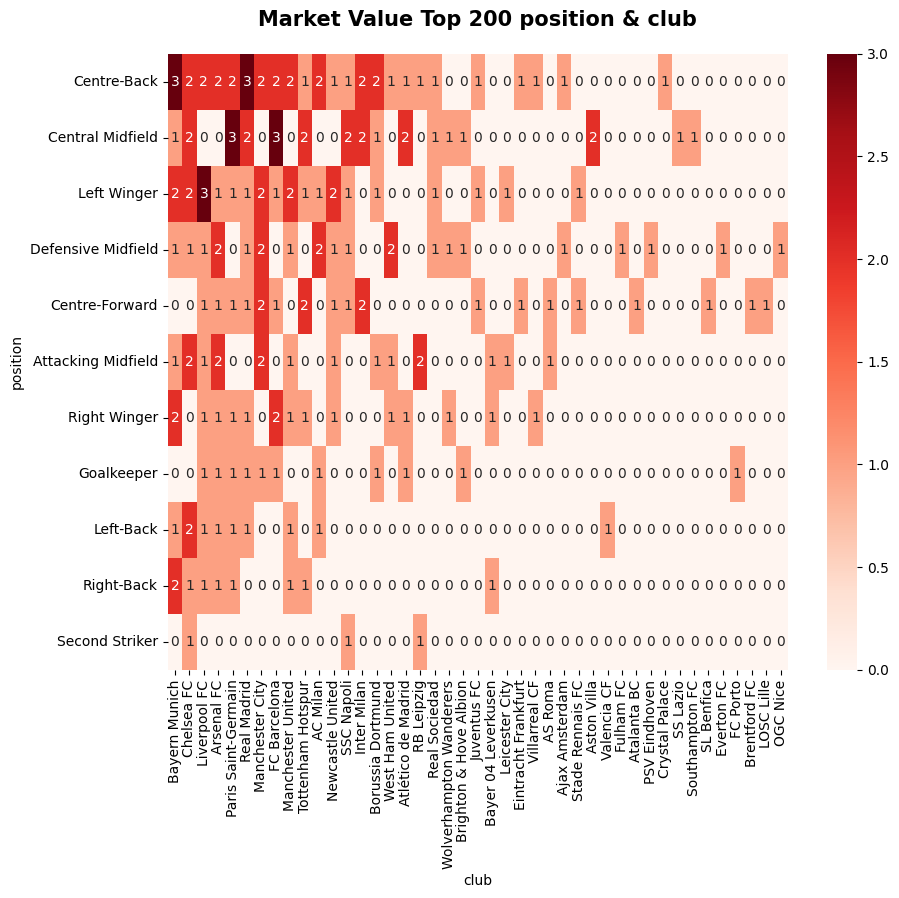

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))
ct = pd.crosstab(df['position'], df['club'])
ct = ct.loc[rank_lst[0], rank_lst[1]]
sns.heatmap(ct, annot=True, cmap='Reds', ax=ax)
ax.set_title('Market Value Top 200 position & club', pad=20, size=15, fontweight='bold')

plt.show()

### **전체/position별/club별 평균 연령은 어떨까?**

* most valuable player의 평균연령은 20대 중반으로 최소 18세부터 최대 35세까지 있다. 
* Goalkeeper의 경우 연령대가 높지만, Second Striker, Attacking Midfield와 같이 공격수는 연령대가 낮다.
* Atalanta BC club은 타 club보다 most valuable player의 연령대가 매우 낮다.

[전체]
최소값 18세, 평균 25.17세, 최댓값 35세

[position 별]
평균 position
Second Striker        23.67
Attacking Midfield    24.35
Right-Back            24.44
Left Winger           24.76
Central Midfield      25.11
Centre-Forward        25.14
Centre-Back           25.18
Left-Back             25.30
Right Winger          25.50
Defensive Midfield    25.61
Goalkeeper            27.00
Name: age, dtype: float64

[club 별]
평균 club
Atalanta BC                20.00
SL Benfica                 21.00
Everton FC                 21.00
Bayer 04 Leverkusen        21.33
OGC Nice                   22.00
Crystal Palace             22.00
Aston Villa                22.50
LOSC Lille                 23.00
Villarreal CF              23.00
Ajax Amsterdam             23.00
RB Leipzig                 23.00
FC Porto                   23.00
Brighton & Hove Albion     23.33
Borussia Dortmund          23.50
Eintracht Frankfurt        23.50
Chelsea FC                 23.85
AC Milan                   24.14
Wolverhampton Wanderers    2

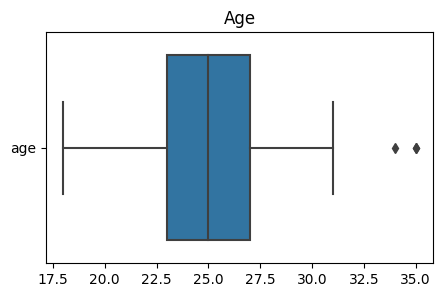

In [223]:
df['age'] = df['age'].astype('int')

import seaborn as sns

fig, ax = plt.subplots(figsize=(5, 3))

ax = sns.boxplot(x='age', data=df)
ax.set_yticklabels(['age'])
ax.set_xlabel('')
ax.set_title('Age')

print(f'[전체]\n최소값 {df["age"].min()}세, 평균 {df["age"].mean()}세, 최댓값 {df["age"].max()}세', end='\n\n')
print(f'[position 별]\n평균 {df.groupby("position")["age"].mean().round(2).sort_values()}', end='\n\n')
print(f'[club 별]\n평균 {df.groupby("club")["age"].mean().round(2).sort_values()}')

### **most valuable player가 가장 많은 나라는 어디일까?**

* France, England, Spain 순으로 출신 player가 가장 많다.
* 대부분 유럽 출신임을 알 수 있다.

In [243]:
# 국적에 대한 dictionary 만들기
nat_dict = {}
for nat in df['nationality']:
    for n in nat.split('|'):
        if n not in nat_dict.keys():
            nat_dict[n] = 1
        else:
            nat_dict[n] += 1

nat_dict = dict(sorted(nat_dict.items(), key=lambda x: x[1], reverse=True))
print('> Market Value Top 200 Nationality Count')
print(list(nat_dict.items())[:10])
print()

# 카운트의 분포 파악하기
from collections import Counter

count = Counter(nat_dict.values())
print('> 최고 count와 최저 count는 뭘까?')
print(count)


> Market Value Top 200 Nationality Count
[('France', 32), ('England', 32), ('Spain', 30), ('Brazil', 22), ('Portugal', 19), ('Germany', 14), ('Italy', 12), ('Argentina', 9), ('Netherlands', 8), ('DR Congo', 6)]

> 최고 count와 최저 count는 뭘까?
Counter({1: 25, 2: 16, 3: 4, 5: 3, 4: 3, 32: 2, 30: 1, 22: 1, 19: 1, 14: 1, 12: 1, 9: 1, 8: 1, 6: 1})


### **우리나라 선수 찾기**

In [ ]:
df.loc[df['nationality']=='Korea, South']

,name,position,nationality,club,value
rank,,,,,
73,Heung-min Son,Left Winger,"Korea, South",Tottenham Hotspur,60.00
84,Min-jae Kim,Centre-Back,"Korea, South",SSC Napoli,50.00
